<a href="https://colab.research.google.com/github/Intertangler/ML4biotech/blob/main/cnn_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## exercise - convolutional neural network for a spatial cell problem
The following artificial dataset is a simulation of a tissue slice where we can think of each point in a 16x16 array as an individual cell. Each cell has 6 genes that we are keeping track of and which have a binary format, i.e. they are either on (1) or off (0). Then there is a status class label, in which we have designated each cell as either cancerous or healthy. The goal of the exercise is to build a convolutional neural network that models the class variable by predicting it from gene expression features. The data have been constructed in such a way as to hide these features to be difficult for linear models to find. But moreover, the cancer tends to cluster into the form of tumors, and thus local spatial correlations should contribute to our ability to predict its location.

### download the dataset
after running the cell below, you can click the folder icon to the right and see if the .csv file is there now. Feel free to look at it and what is in it.

In [43]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [48]:
%%R
library(httr)

download_from_github <- function(url, filename) {
  response <- GET(url)
  if (http_status(response)$category == "Success") {
    writeBin(content(response, "raw"), filename)
  } else {
    cat(paste("Failed :", status_code(response)), "\n")
  }
}

url <- 'https://raw.githubusercontent.com/Intertangler/ML4biotech/main/all_tissue_slices.csv'
filename <- 'all_tissue_slices.csv'
download_from_github(url, filename)


### load the data into variables
We will import the data into programming variables in order to handle them hereafter. We will make use of a reverse lookup table which will be for mapping rectangular matrix indices back to the hexagonal lattice coordinates of the cell positions. Also note how gene expression values (1's and 0's) are stored in the "lattice" variable.

In [49]:
%%R
library(dplyr)
library(tidyverse)

load_slices_from_csv <- function(n_genes, filename='all_tissue_slices.csv') {
  df <- read.csv(filename, stringsAsFactors = FALSE)

  all_slices <- list()

  # we group by slice id
  grouped <- split(df, df$Tissue_Slice_ID)

  for(name in names(grouped)) {
    group <- grouped[[name]]

    lattice <- list()
    cancer_status <- list()
    effector_status <- list()
    pathology_counter <- list()
    reverse_lookup <- list()# reverse lookup to remap back to hex coordinates

    for(row in 1:nrow(group)) {
      x <- as.numeric(group[row, 'x'])
      y <- as.numeric(group[row, 'y'])
      row_idx <- as.integer(group[row, 'row_idx'])# extract row and col indexes
      col_idx <- as.integer(group[row, 'col_idx'])
      is_cancer <- group[row, 'is_cancer']
      is_effector <- group[row, 'is_effector']
      genes <- as.numeric(group[row, grep(paste0("^gene_([1-", n_genes, "])$"), colnames(group))])
      pathology <- group[row, 'pathology_counter']
# fill variables with data for this slice
      lattice[paste(x, y, sep = "-")] <- list(genes)
      cancer_status[paste(x, y, sep = "-")] <- is_cancer
      effector_status[paste(x, y, sep = "-")] <- is_effector
      pathology_counter[paste(x, y, sep = "-")] <- pathology
      reverse_lookup[paste(x, y, sep = "-")] <- c(row_idx, col_idx) # update reverse_lookup w data
    }
# Store the reconstructed data for this slice in 'all_slices'
    all_slices[[name]] <- list(lattice = lattice, cancer_status = cancer_status,
                               effector_status = effector_status, pathology_counter = pathology_counter,
                               reverse_lookup = reverse_lookup)
  }

  return(all_slices)
}

# Load the data f
all_slices <- load_slices_from_csv(n_genes = 6)



### visualize some of the slices
Below we can visualize the class labels (healthy and cancerous) - there is a third one called effector which we will ignore.

Then we have a "pathology counter" which is actually a hidden variable computed from the artificially rigged interactions between nearby cells. This variable is correlated to the cancer status of each cell. But we do not have direct access to it from the gene expression data alone.

Then lastly, we have the gene expression data visualized using RGB. Although there are 6 genes, the first 3 have been mapped to rgb colors. So a cell colored magenta would indicate, for example, that the cell expresses 2 out of 3 of the genes being plotted (i.e. a combination of red and blue). A white colored cell expresses all 3, and black expresses none.

Try examining some of the slices to see if you discern any visual pattern in the raw gene expression data corresponding to the ground truth class variable.



In [53]:
%%R
slice_1_data <- all_slices[['slice_2']]
reverse_lookup <- slice_1_data[['reverse_lookup']]

lattice <- slice_1_data[['lattice']]
cancer_status <- slice_1_data[['cancer_status']]
effector_status <- slice_1_data[['effector_status']]
pathology_counter <- slice_1_data[['pathology_counter']]


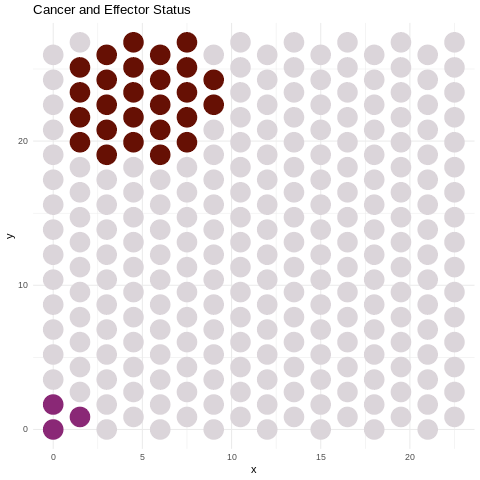

In [50]:
%%R
library(ggplot2)

df_cancer <- data.frame(coordinates = names(cancer_status), status = unlist(cancer_status), stringsAsFactors = FALSE)
df_effector <- data.frame(coordinates = names(effector_status), status = unlist(effector_status), stringsAsFactors = FALSE)

df <- merge(df_cancer, df_effector, by = "coordinates", suffixes = c("_cancer", "_effector"))
df$color <- ifelse(df$status_cancer == "True", "#661004", # Cancer cells
                   ifelse(df$status_effector == "True", "#8a2876", # Effector cells
                          "#dbd5da")) # Normal cells
df$x <- as.numeric(unlist(lapply(strsplit(df$coordinates, "-"), `[`, 1)))
df$y <- as.numeric(unlist(lapply(strsplit(df$coordinates, "-"), `[`, 2)))

# Plotting part
ggplot(df, aes(x = x, y = y, color = color)) +
  geom_point(size = 9) +
  scale_color_identity() +
  theme_minimal() +
  ggtitle("Cancer and Effector Status") +
  theme(legend.position = "none")


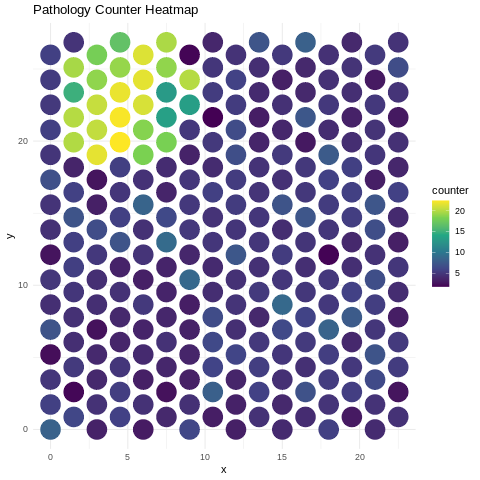

In [54]:
%%R
library(ggplot2)

visualize_pathology_counter <- function(radius, pathology_counter) {
  df_pathology <- data.frame(coordinates = names(pathology_counter),
                             counter = unlist(pathology_counter),
                             stringsAsFactors = FALSE)
  df_pathology$x <- as.numeric(unlist(lapply(strsplit(df_pathology$coordinates, "-"), `[`, 1)))
  df_pathology$y <- as.numeric(unlist(lapply(strsplit(df_pathology$coordinates, "-"), `[`, 2)))
  plot <- ggplot(df_pathology, aes(x = x, y = y, color = counter)) +
    geom_point(size = 9) +
    scale_color_viridis_c() +  #  color scale
    theme_minimal() +
    ggtitle("Pathology Counter Heatmap") +
    theme(legend.position = "right")
  return(plot)
}


visualize_pathology_counter(1,pathology_counter)


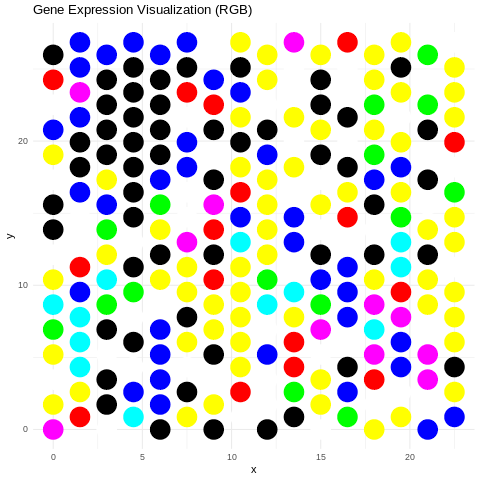

In [52]:
%%R

df_genes <- data.frame(coordinates = names(lattice),
                       r = unlist(lapply(lattice, `[`, 1)),
                       g = unlist(lapply(lattice, `[`, 2)),
                       b = unlist(lapply(lattice, `[`, 3)),
                       stringsAsFactors = FALSE)
df_genes$x <- as.numeric(unlist(lapply(strsplit(df_genes$coordinates, "-"), `[`, 1)))
df_genes$y <- as.numeric(unlist(lapply(strsplit(df_genes$coordinates, "-"), `[`, 2)))
df_genes$color <- apply(df_genes[, c("r", "g", "b")], 1, function(row) {
  rgb(row[1], row[2], row[3], maxColorValue = 1)
})

ggplot(df_genes, aes(x = x, y = y, color = color)) +
  geom_point(size = 9, aes(fill = color), shape = 21) +
  scale_color_identity() +
  scale_fill_identity() +
  theme_minimal() +
  ggtitle("Gene Expression Visualization (RGB)") +
  theme(legend.position = "none")

In [ ]:
%%R
install.packages("keras")

### functions for preparing the data as cnn input
these functions will be used to import the data and format it as a matrix appropriate as the input to the cnn

In [55]:
%%R
library(keras)
library(readr)

# Convert lattice to cnn input
lattice_to_cnn_input <- function(lattice, reverse_lookup, dims=c(16,16), n_genes) {
  cnn_input <- array(0, dim = c(dims[1], dims[2], n_genes))

  for (key in names(lattice)) {
    x_y <- unlist(strsplit(key, split=","))
    x <- as.numeric(x_y[1])
    y <- as.numeric(x_y[2])
    row_idx <- reverse_lookup[[key]][1]
    col_idx <- reverse_lookup[[key]][2]
    cnn_input[row_idx, col_idx,] <- unlist(lattice[[key]])
  }

  return(cnn_input)
}

csv_to_lattices_and_labels <- function(filename, dims=c(16, 16), n_genes=6) {
  data <- read.csv(filename, header=TRUE, stringsAsFactors=FALSE)

  unique_slices <- unique(data$Tissue_Slice_ID)
  lattices <- list()
  reverse_lookups <- list()
  labels <- array(0, dim = c(length(unique_slices), dims[1], dims[2]))

  for (i in 1:nrow(data)) {
    tissue_slice_id <- data$Tissue_Slice_ID[i]
    x <- data$x[i]
    y <- data$y[i]
    row_idx <- data$row_idx[i]
    col_idx <- data$col_idx[i]
    is_cancer <- ifelse(tolower(data$is_cancer[i]) == "true", 1.0, 0.0)

    genes <- as.numeric(data[i, 8:13])

    key <- paste(x, y, sep=",")

    if (!(tissue_slice_id %in% names(lattices))) {
      lattices[[tissue_slice_id]] <- list()
      reverse_lookups[[tissue_slice_id]] <- list()
    }

    lattices[[tissue_slice_id]][[key]] <- genes
    reverse_lookups[[tissue_slice_id]][[key]] <- c(row_idx, col_idx)
    slice_idx <- which(unique_slices == tissue_slice_id)
    labels[slice_idx, row_idx, col_idx] <- is_cancer
  }

  lattices_array <- array(0, dim = c(length(unique_slices), dims[1], dims[2], n_genes))
  for (i in 1:length(unique_slices)) {
    lattices_array[i,,,] <- lattice_to_cnn_input(lattices[[unique_slices[i]]], reverse_lookups[[unique_slices[i]]], n_genes=n_genes)
  }

  return(list(lattices = lattices_array, labels = labels))
}


## exercise part - build the cnn architecture
Using your experience from the previous exercises in which we have used Keras to contruct neural networks, set up a model including the the architecture with convolutional layers (see the documentation from Keras for how to do this https://keras.io/api/layers/convolution_layers/convolution2d/). And set up the compilation, training, and testing as we have done previously for other neural networks.

In [ ]:
%%R

# Load the data from csv file
datax <- csv_to_lattices_and_labels('all_tissue_slices.csv')

# Train-test split - split the data into training and tests sets
set.seed(1234)
indexes <- sample(1:dim(datax$lattices)[1], size = 0.8 * dim(datax$lattices)[1])
train_data <- datax$lattices[indexes, , , ]
test_data <- datax$lattices[-indexes, , , ]
train_labels <- datax$labels[indexes, , ]
test_labels <- datax$labels[-indexes, , ]

# Define the CNN model
input_tensor <- layer_input(shape = c(16, 16, 6))
# add a convolutional layer here with a certain number of kernels, specify dimensions of the kernel e.g. 3x3
# remember to choose an activation function
# structure the output layer to have analogous dimensions as the input,
#i.e. a 16x16 array except instead of 6-element gene vector, a 1-element class variable
# we want the activation function for the last layer to be a sigmoid
#🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟#
#🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟#
#🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟#


model <- keras_model(inputs = input_tensor, outputs = x)

# Compile the model
model %>% compile( #🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟

)

# Train the model
history <- model %>% fit( #🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟

)

# Predict
y_pred <- model %>% predict(test_data)

### verify visually
To see if the model is working, let's perform some side-by-side comparisons of the test data (cancer label) with our predicted outcome activation values.

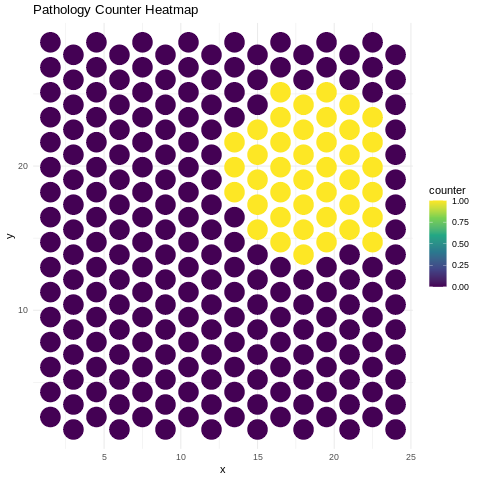

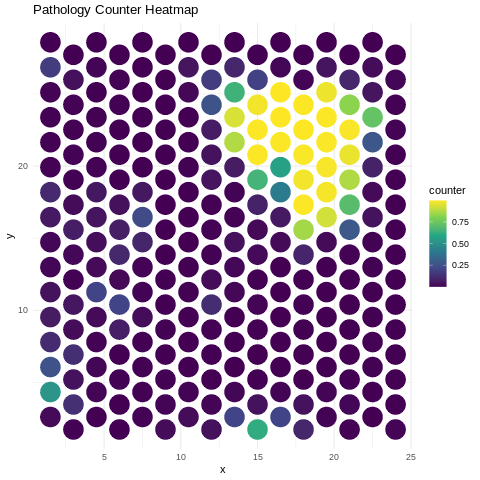

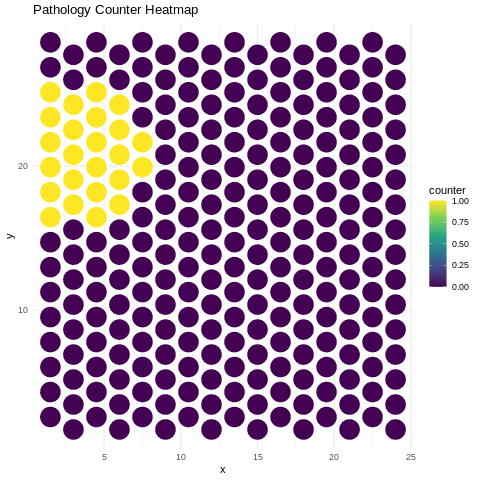

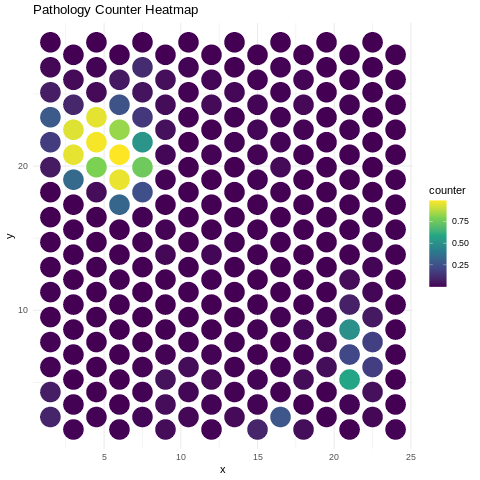

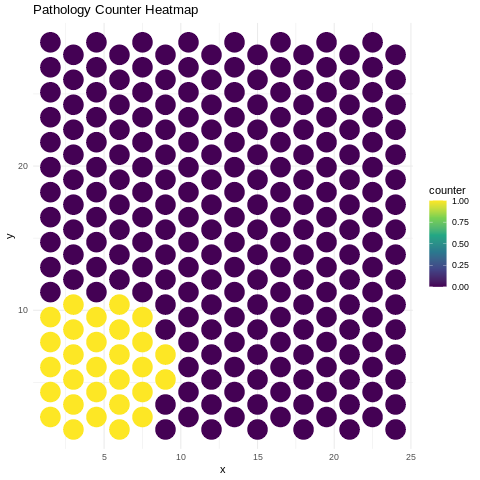

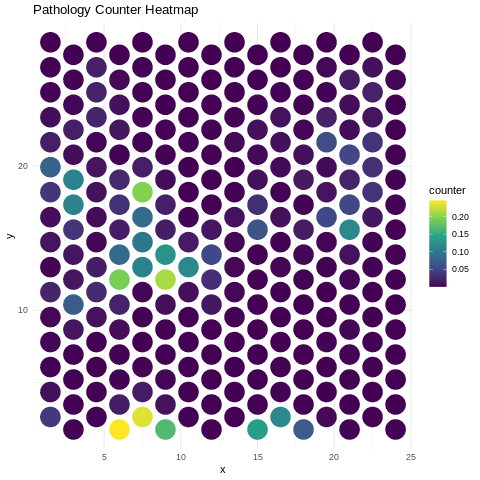

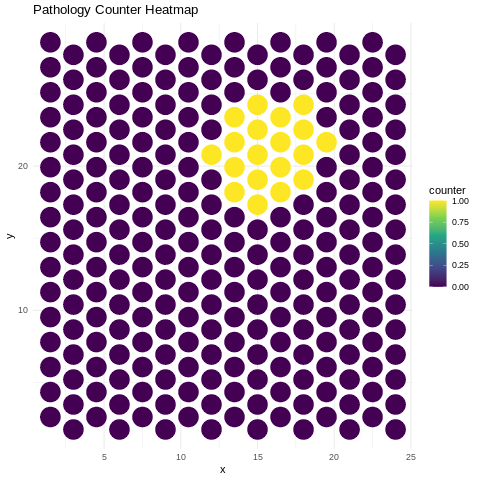

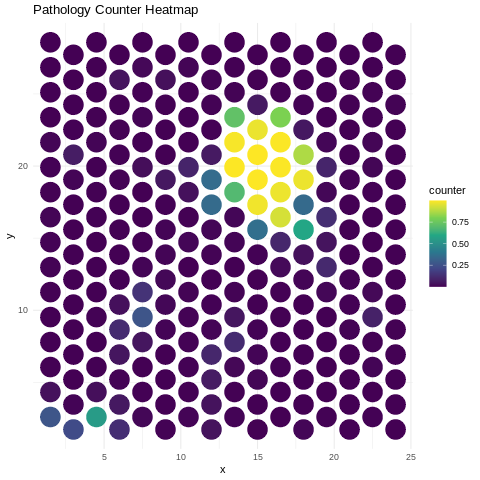

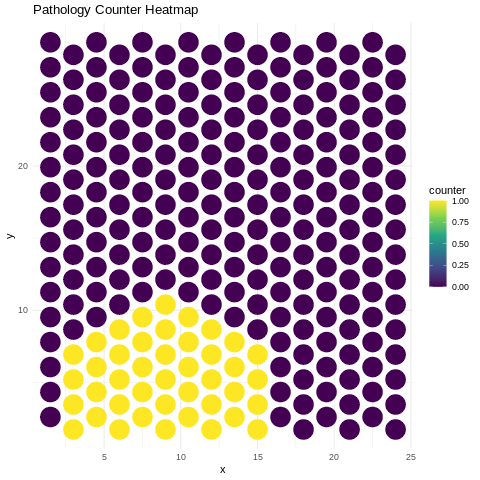

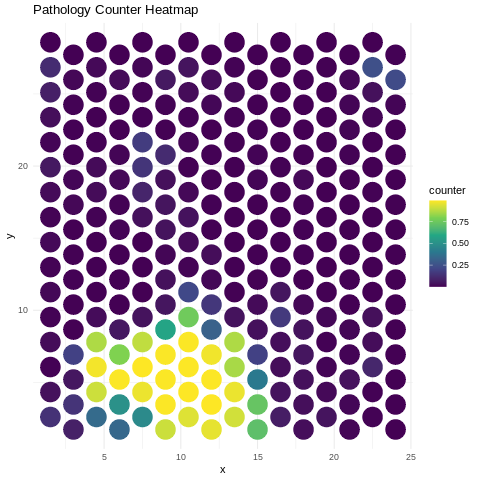

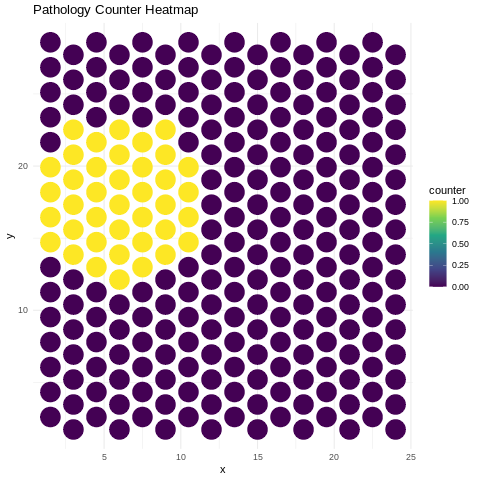

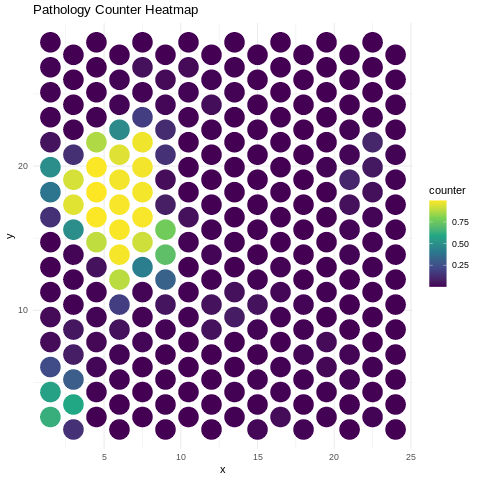

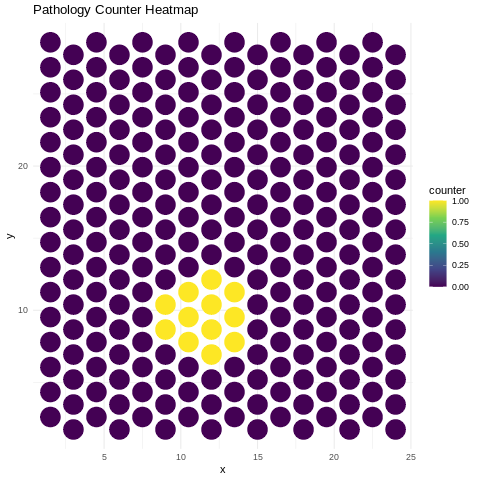

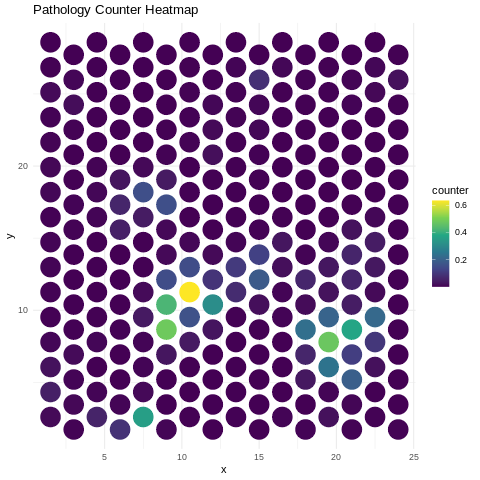

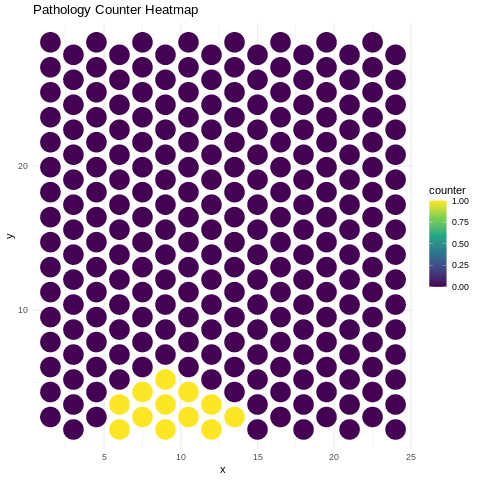

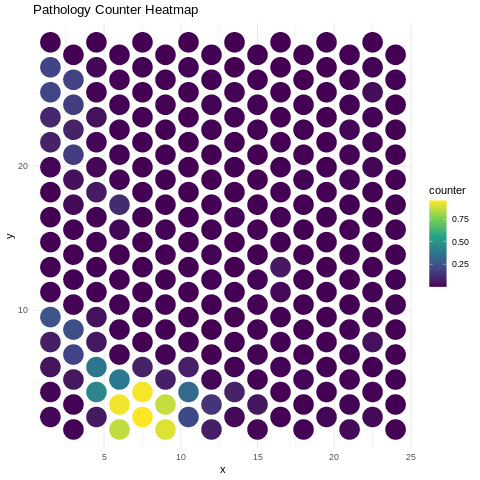

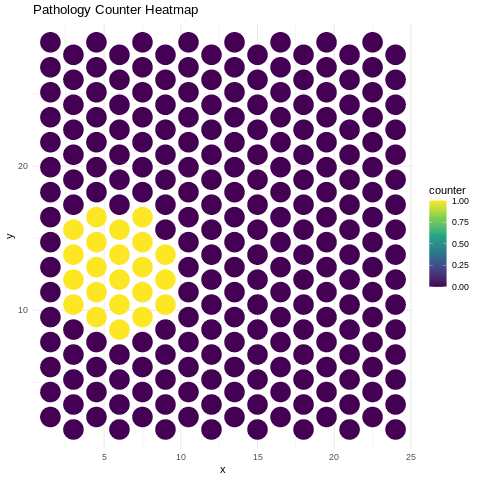

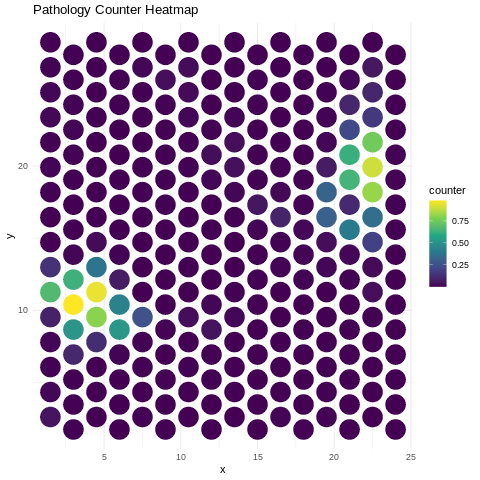

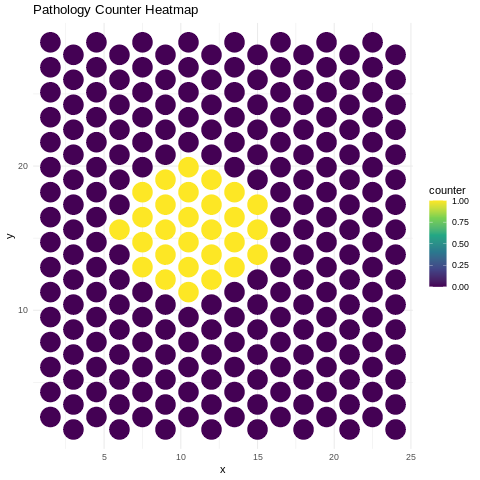

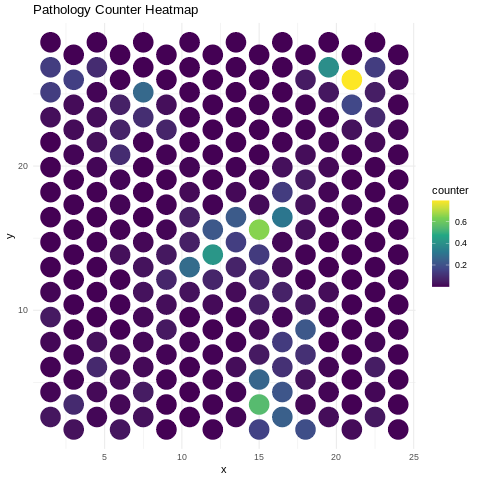

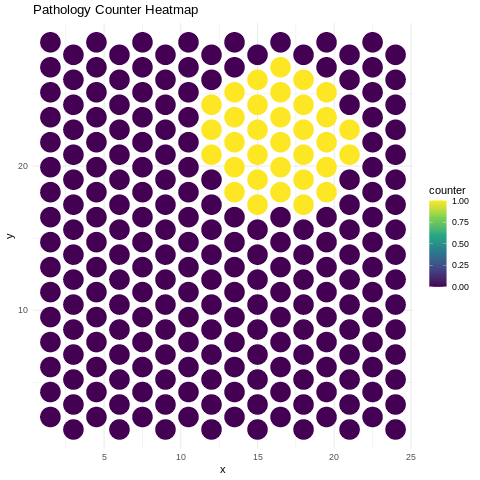

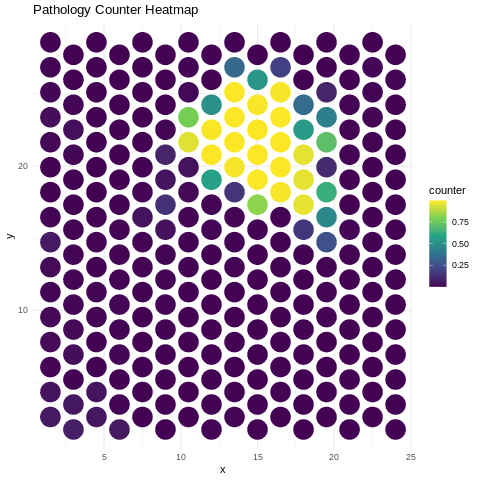

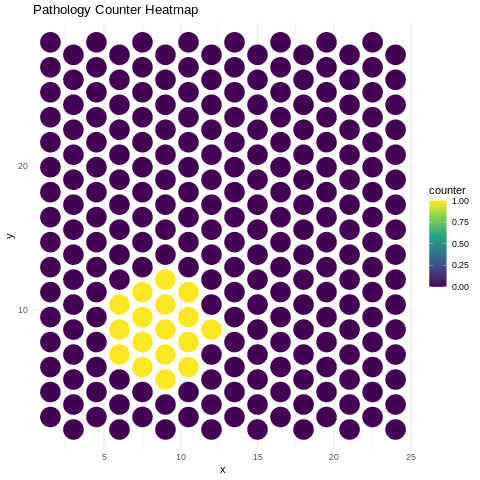

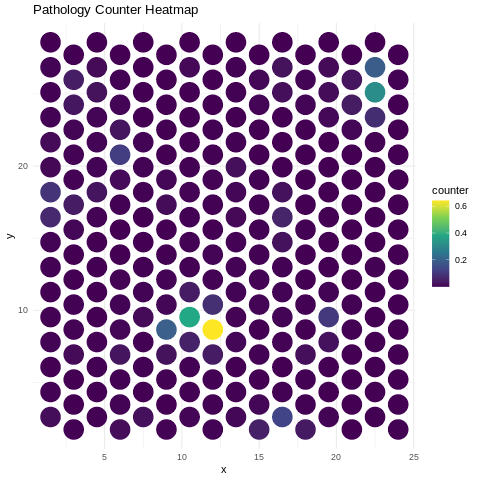

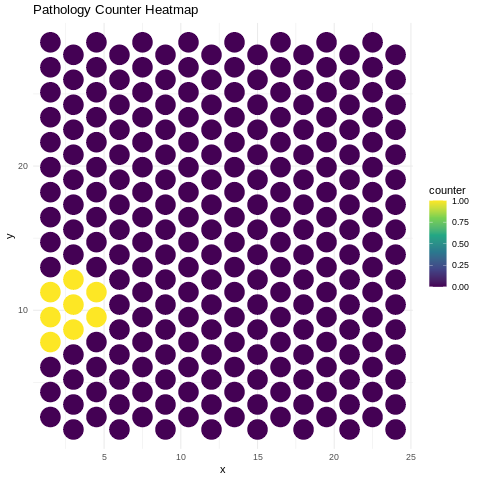

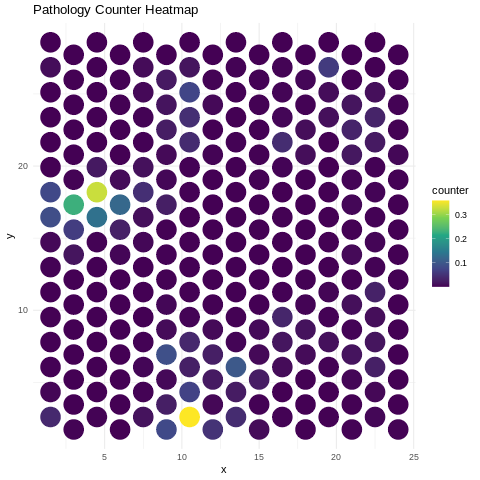

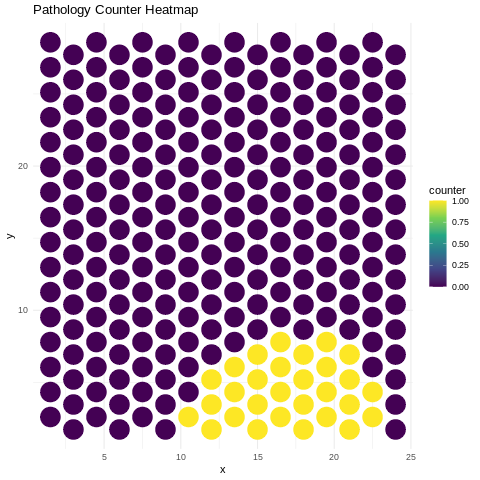

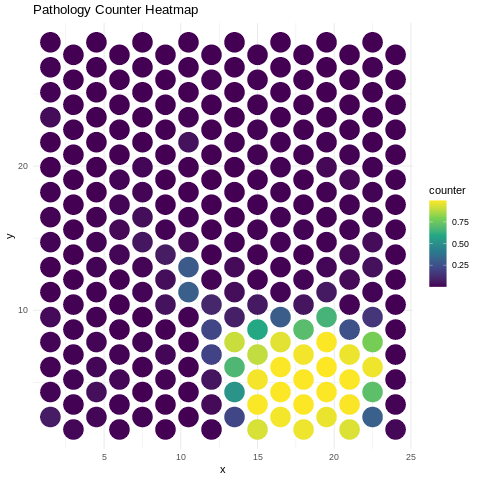

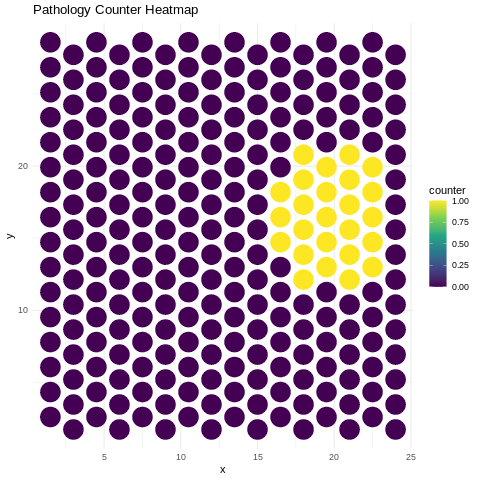

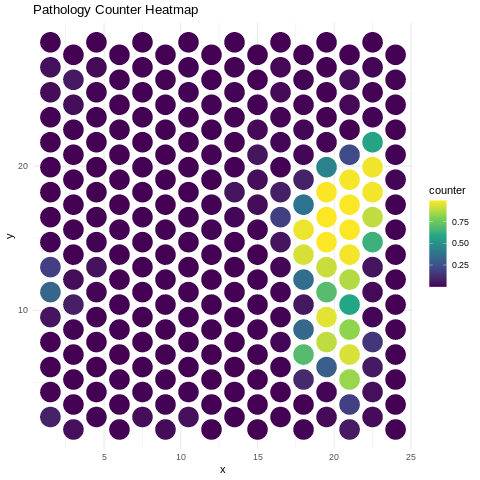

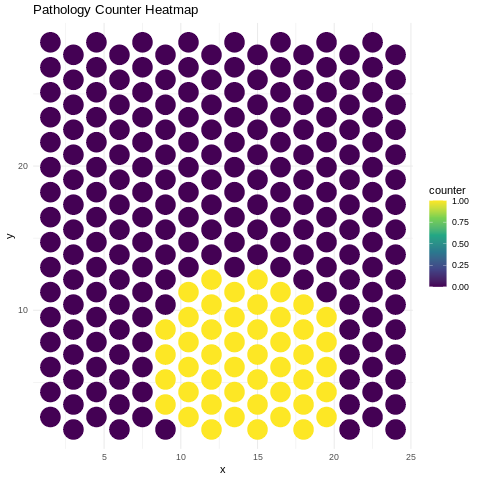

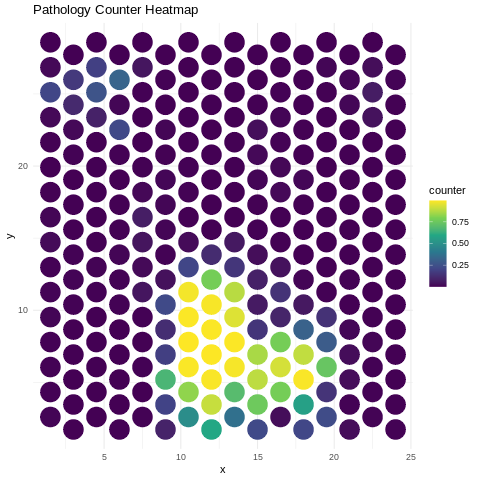

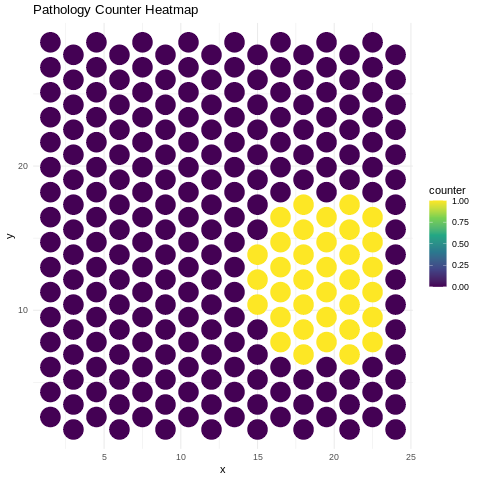

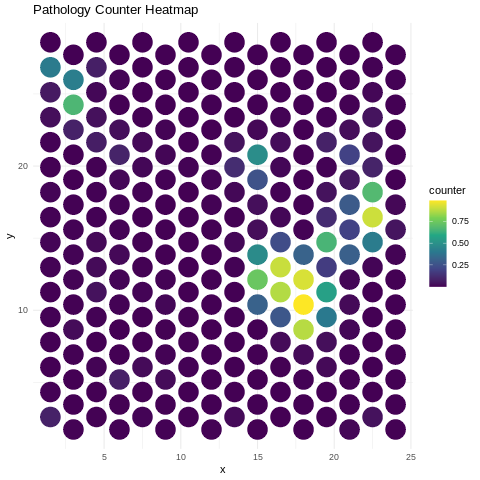

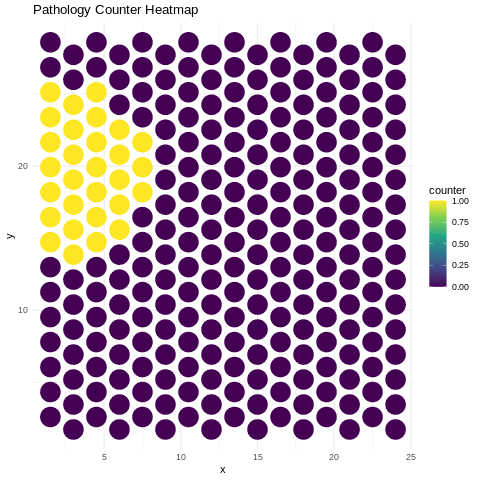

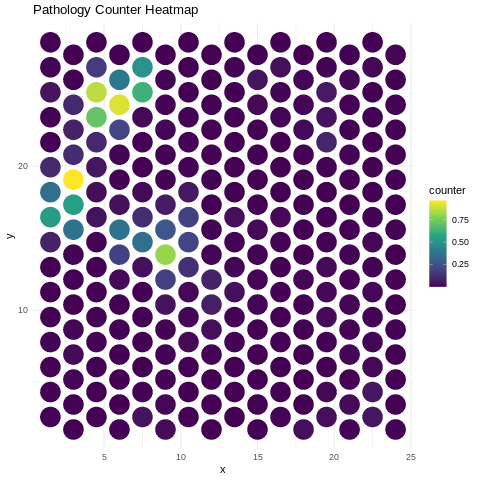

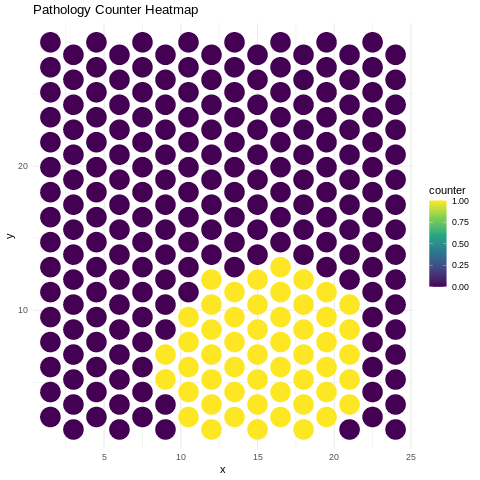

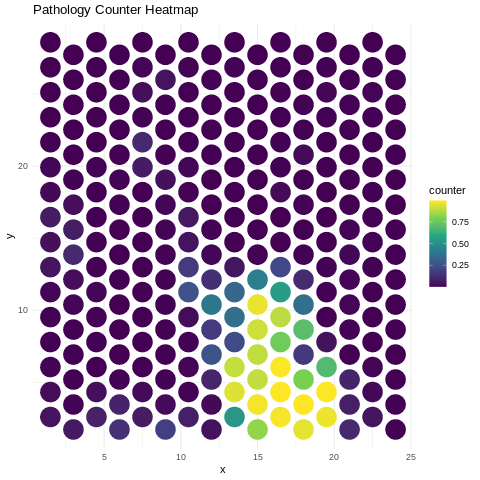

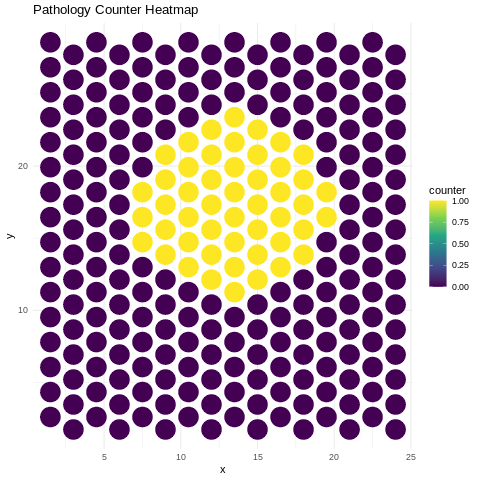

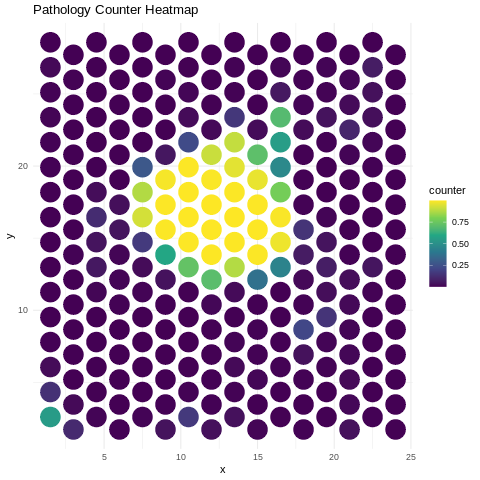

In [ ]:
%%R
library(ggplot2)


visualize_test_labels <- function(radius, test_labels_slice, dims=c(16, 16)) {
  pathology_counter <- list()

  for (row in 1:dims[1]) {
    for (col in 1:dims[2]) {
      x <- round(col * 1.5 * radius, 3)
      y <- round(row * sqrt(3) * radius, 3)
      if (col %% 2 == 1) {
        y <- y + round(sqrt(3)/2 * radius, 3)
      }
      coord_key <- paste0(x, "-", y)
      pathology_counter[[coord_key]] <- test_labels_slice[row, col]
    }
  }

  visualize_pathology_counter(radius, pathology_counter)
}
visualize_test_labels <- function(radius, test_labels, dims=c(16, 16)) {
  pathology_counter <- list()
  for(row in 1:dims[1]) {
    for(col in 1:dims[2]) {
      x <- round(col * 1.5 * radius, 3)
      y <- round(row * sqrt(3) * radius, 3)
      if (col %% 2 == 1) {
        y <- y + round(sqrt(3)/2 * radius, 3)
      }
      pathology_counter[paste0(x, "-", y)] <- test_labels[row, col]
    }
  }
  return(visualize_pathology_counter(radius, pathology_counter))
}

for(i in 1:dim(test_data)[1]) {
  print(visualize_test_labels(1, test_labels[i,,]))
  print(visualize_predictions(1, y_pred, sample_index = i))
}


